# Generate your own chronographic walk isochrones
Just set up the center point using Longitude and Latitude coordinates and pass the list of time steps.

The notebook will automatically download the graph for the given area a plot the output.

<a target="_blank" href="https://colab.research.google.com/github/RaczeQ/isochrone-transform/blob/main/generate_isochrones.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
# Install these libraries
# %pip install contextily geopandas osmnx quackosm matplotlib tqdm

In [2]:
import math
import warnings
from contextlib import suppress
from itertools import pairwise

import contextily as cx
import geopandas as gpd
import networkx as nx
import numpy as np
import osmnx as ox
from matplotlib import pyplot as plt
from quackosm import convert_geometry_to_geodataframe
from shapely import (
    LinearRing,
    LineString,
    Point,
    Polygon,
    distance,
    polygonize,
    unary_union,
)
from shapely.coords import CoordinateSequence
from tqdm import tqdm, trange

In [3]:
CENTER_POINT = Point(-0.12425030075527455, 51.5009693399811) # Big Ben in London
ISOCHRONES_TIME_STEPS_MINUTES = [5, 10, 15, 20, 25] # keep it a list, even if with a single value
WALK_SPEED_KMPH = 4.8 # from Transport for London design guidelines

In [4]:
walk_speed_meters_per_minute = WALK_SPEED_KMPH * 1000 / 60
max_distance_meters = max(ISOCHRONES_TIME_STEPS_MINUTES) * walk_speed_meters_per_minute
projected_point, projected_crs = ox.projection.project_geometry(CENTER_POINT)
query_buffer, _ = ox.projection.project_geometry(
    projected_point.buffer(max_distance_meters),
    crs=projected_crs,
    to_latlong=True,
)

In [5]:
def download_graph():
    G = ox.graph_from_polygon(
        query_buffer,
        network_type="walk",
        truncate_by_edge=True,
    )

    for _, _, _, data in G.edges(data=True, keys=True):
        data["time"] = data["length"] / walk_speed_meters_per_minute

    return G


def download_buildings():
    return convert_geometry_to_geodataframe(
        query_buffer, tags_filter={"building": True}
    )

In [6]:
G = download_graph()
buildings_gdf = download_buildings()
center_node_id = ox.nearest_nodes(G, X=CENTER_POINT.x, Y=CENTER_POINT.y)
center_node_point = Point(G.nodes[center_node_id]["x"], G.nodes[center_node_id]["y"])

In [7]:
shortest_path_cache = {}

def subgraph_from_edge_pairs(G: nx.MultiDiGraph, edge_pairs: list[tuple[int, int]]):
    """
    Return a MultiDiGraph containing only edges whose endpoints match edge_pairs.
    - G: original MultiDiGraph (osmnx graph)
    - edge_pairs: iterable of (u, v) tuples (node ids). Treated as directed by default.
    """
    G_out = nx.MultiDiGraph()
    G_out.graph.update(G.graph)
    edge_set = set(edge_pairs)

    # add nodes that will be used (copy node attributes)
    nodes_to_add = set()
    for u, v in edge_set:
        if u in G:
            nodes_to_add.add(u)
        if v in G:
            nodes_to_add.add(v)
    for n in nodes_to_add:
        G_out.add_node(n, **G.nodes[n])

    # copy matching edges (preserve keys and attributes)
    for u, v, key, data in G.edges(keys=True, data=True):
        if (u, v) in edge_set:
            # ensure nodes exist in G_out (they should from nodes_to_add, but double-check)
            if not G_out.has_node(u):
                G_out.add_node(u, **G.nodes[u])
            if not G_out.has_node(v):
                G_out.add_node(v, **G.nodes[v])
            G_out.add_edge(u, v, key=key, **data)

    return G_out


def cut_linestring(line: LineString, distance: float) -> list[LineString]:
    if distance <= 0.0:
        return [line]
    elif distance >= 1.0:
        return [line]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p), normalized=True)
        if pd == distance:
            return [LineString(coords[: i + 1]), LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance, normalized=True)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:]),
            ]

    raise RuntimeError


def get_path_length(u, graph, no_cache: bool = False):
    cache_key = (center_node_id, u)
    if cache_key not in shortest_path_cache:
        path = ox.shortest_path(graph, center_node_id, u, weight="time")
        if not path:
            raise RuntimeError
        path_length = sum(
            min(d["time"] for d in graph.get_edge_data(u, v).values())
            for u, v in pairwise(path)
        )
        shortest_path_cache[cache_key] = path_length
    length = shortest_path_cache[cache_key]

    return length


def truncate_osmnx_graph(graph: nx.MultiDiGraph, center_point: Point, time: float):
    subgraph_edges = None
    center_node = ox.nearest_nodes(graph, X=center_point.x, Y=center_point.y)
    subgraph = ox.truncate.truncate_graph_dist(
        graph, center_node, time, weight="time"
    )
    with suppress(ValueError):
        subgraph_edges = ox.graph_to_gdfs(subgraph, nodes=False, edges=True)

    # find all endpoints and check their edges outside. Clip edges exactly at the distance point.
    edges_to_clip = {}
    for node in set(subgraph.nodes).union([center_node]):
        for u, v, data in graph.edges(node, keys=False, data=True):
            if v in subgraph:
                continue

            length = get_path_length(u, subgraph)
            length_left = time - length
            if length_left > 0:
                edges_to_clip[(u, v)] = length_left
            else:
                print((u, v), length, length_left)

    pruned_edges = ox.graph_to_gdfs(
        subgraph_from_edge_pairs(graph, list(edges_to_clip.keys())),
        nodes=False,
        edges=True,
    )

    clipped_edges_geometries = []
    for (u, v), length_clip in edges_to_clip.items():
        with warnings.catch_warnings(action="ignore"):
            edge = pruned_edges.loc[(u, v)].iloc[0]
        edge_length = edge["time"]
        edge_linestring = edge["geometry"]
        interpolation_ratio = length_clip / edge_length
        clipped_edge = cut_linestring(edge_linestring, interpolation_ratio)[0]
        clipped_edges_geometries.append(clipped_edge)

    clipped_edges_gdf = gpd.GeoDataFrame(
        geometry=gpd.GeoSeries(clipped_edges_geometries, crs=4326),
    )
    clipped_edges_gdf["clipped"] = True
    if subgraph_edges is not None:
        subgraph_edges["clipped"] = False
        all_edges_gdf = gpd.pd.concat(
            [
                subgraph_edges[["geometry", "clipped"]],
                clipped_edges_gdf,
            ],
            ignore_index=True,
        )
    else:
        all_edges_gdf = clipped_edges_gdf

    return all_edges_gdf

In [8]:
def locate_farthest_intersection_point(
    center_point: Point,
    convex_hull_boundary: LineString,
    angle: float,
    raise_if_multiple: bool = False,
):
    ray_length = 1e5
    angle_rad = math.radians(angle)
    ray_endpoint = Point(
        center_point.x + ray_length * math.cos(angle_rad),
        center_point.y + ray_length * math.sin(angle_rad),
    )
    ray = LineString([center_point, ray_endpoint])
    intersection = convex_hull_boundary.intersection(ray)

    if intersection.is_empty:
        return None
    elif intersection.geom_type == "Point":
        return intersection
    elif intersection.geom_type in ["MultiPoint", "GeometryCollection"]:
        if raise_if_multiple:
            raise RuntimeError
        points = [geom for geom in intersection.geoms if geom.geom_type == "Point"]
        if not points:
            return None
        closest_point = max(points, key=lambda point: center_point.distance(point))
        return closest_point
    else:
        return None


def get_bearing(lat1, long1, lat2, long2):
    dLon = long2 - long1
    x = np.cos(np.radians(lat2)) * np.sin(np.radians(dLon))
    y = np.cos(np.radians(lat1)) * np.sin(np.radians(lat2)) - np.sin(
        np.radians(lat1)
    ) * np.cos(np.radians(lat2)) * np.cos(np.radians(dLon))
    brng = np.arctan2(x, y)
    brng = np.degrees(brng)

    return brng


def get_angle(point1: Point, point2: Point):
    rads = np.arctan2(point2.y - point1.y, point2.x - point1.x)
    return np.degrees(rads)


def transform_point(
    point: Point, center_point: Point, isochrone_boundary: Polygon
) -> Point:
    angle = get_angle(center_point, point)
    intersection_point = locate_farthest_intersection_point(
        center_point, isochrone_boundary.exterior, angle
    )

    distance_from_isochrone_boundary = distance(center_point, intersection_point)
    distance_from_current_point = distance(center_point, point)
    distance_ratio = min(
        1, distance_from_current_point / distance_from_isochrone_boundary
    )

    length = distance_ratio

    angle_rad = np.radians(angle)

    new_point = Point(length * np.cos(angle_rad), length * np.sin(angle_rad))

    return new_point


def transform_coords(
    coords: CoordinateSequence,
    center_point: Point,
    isochrone_boundary: Polygon,
) -> list[Point]:
    result = []
    coords_list = list(coords)
    for (x1, y1), (x2, y2) in pairwise(coords_list):
        result.append(transform_point(Point(x1, y1), center_point, isochrone_boundary))
        ls = LineString([(x1, y1), (x2, y2)])
        step = 1 / 8
        for idx in np.arange(0, 1, step):
            result.append(
                transform_point(
                    ls.interpolate(idx, normalized=True),
                    center_point,
                    isochrone_boundary,
                )
            )

    result.append(
        transform_point(Point(coords_list[-1]), center_point, isochrone_boundary)
    )
    return result


def transform_geometries(
    gs: gpd.GeoSeries,
    center_point: Point,
    isochrone_boundary: Polygon,
):
    geoms = []
    for geometry in gs:
        if isinstance(geometry, Polygon):
            transformed_ex = transform_coords(
                geometry.exterior.coords,
                center_point,
                isochrone_boundary,
            )
            transformed_ins = [
                transform_coords(interior.coords, center_point, isochrone_boundary)
                for interior in geometry.interiors
            ]
            geoms.append(Polygon(transformed_ex, transformed_ins))
        elif isinstance(geometry, LineString):
            transformed_coords = transform_coords(
                geometry.coords, center_point, isochrone_boundary
            )
            geoms.append(LineString(transformed_coords))

    return gpd.GeoSeries(geoms)


def generate_isochone_boundary(
    clipped_edges: gpd.GeoDataFrame,
    edges_union: gpd.GeoSeries,
    previous_boundary: Polygon | None = None,
) -> Polygon:
    all_points = gpd.GeoSeries(
        clipped_edges.get_coordinates(ignore_index=True).apply(
            lambda row: Point(row["x"], row["y"]), axis=1
        ),
        crs=4326,
    )
    points_outside_boundary = gpd.GeoSeries([], crs=4326)
    end_points = clipped_edges[clipped_edges["clipped"]].geometry.apply(
        lambda ls: Point(ls.coords[-1])
    )

    sorted_end_points = gpd.GeoSeries(
        sorted(end_points, key=lambda pt: get_angle(center_node_point, pt)), crs=4326
    ).drop_duplicates()
    isochrone_boundary = unary_union(
        polygonize(edges_union.union(LinearRing(sorted_end_points)).to_list()).geoms
    )

    points_outside_boundary = all_points[~all_points.intersects(isochrone_boundary)]
    if len(points_outside_boundary) > 0:
        end_points = gpd.pd.concat([end_points, points_outside_boundary])
        sorted_end_points = gpd.GeoSeries(
            sorted(end_points, key=lambda pt: get_angle(center_node_point, pt)),
            crs=4326,
        ).drop_duplicates()
        isochrone_boundary = unary_union(
            polygonize(edges_union.union(LinearRing(sorted_end_points)).to_list()).geoms
        )

    if previous_boundary is not None:
        isochrone_boundary = isochrone_boundary.union(previous_boundary)

    if isochrone_boundary.geom_type == "MultiPolygon":
        isochrone_boundary = sorted(
            isochrone_boundary.geoms, key=lambda g: g.area, reverse=True
        )[0]

    return isochrone_boundary


def generate_isochrone_data(
    time_step: float,
    previous_boundary: Polygon | None = None,
    return_transformed_geometries: bool = True,
):
    clipped_edges = truncate_osmnx_graph(G, center_node_point, time_step)
    edges_union = gpd.GeoSeries([clipped_edges.union_all()], crs=4326)

    isochrone_boundary = generate_isochone_boundary(
        clipped_edges, edges_union, previous_boundary
    )

    clipped_buildings = buildings_gdf.clip(isochrone_boundary).explode()
    clipped_buildings = clipped_buildings[clipped_buildings.geom_type == "Polygon"]

    if not return_transformed_geometries:
        return isochrone_boundary, clipped_buildings, edges_union

    transformed_buildings = transform_geometries(
        clipped_buildings.geometry, center_node_point, isochrone_boundary
    )
    transformed_edges = transform_geometries(
        edges_union.explode(), center_node_point, isochrone_boundary
    )

    return (
        isochrone_boundary,
        clipped_buildings,
        edges_union,
        transformed_buildings,
        transformed_edges,
    )

In [9]:
def transform_point_between_isochrones(
    point: Point,
    center_point: Point,
    isochrone_boundary_far: Polygon,
    isochrone_boundary_close: Polygon | None,
    vector_start=0.0,
    vector_length=1.0,
) -> Point:
    angle = get_angle(center_point, point)
    intersection_point = locate_farthest_intersection_point(
        center_point, isochrone_boundary_far.exterior, angle
    )
    distance_from_far_isochrone_boundary = distance(center_point, intersection_point)
    distance_from_current_point = distance(center_point, point)

    if isochrone_boundary_close is None:
        distance_ratio = min(
            1, distance_from_current_point / distance_from_far_isochrone_boundary
        )
    else:
        close_intersection_point = locate_farthest_intersection_point(
            center_point, isochrone_boundary_close.exterior, angle
        )
        distance_from_close_isochrone_boundary = distance(
            center_point, close_intersection_point
        )
        distance_ratio = min(
            1,
            (distance_from_current_point - distance_from_close_isochrone_boundary)
            / (
                distance_from_far_isochrone_boundary
                - distance_from_close_isochrone_boundary
            ),
        )

    length = vector_length * distance_ratio + vector_start

    angle_rad = np.radians(angle)

    new_point = Point(length * np.cos(angle_rad), length * np.sin(angle_rad))

    return new_point


def transform_coords_between_isochrones(
    coords: CoordinateSequence,
    center_point: Point,
    isochrone_boundary_far: Polygon,
    isochrone_boundary_close: Polygon | None,
    vector_start=0.0,
    vector_length=1.0,
) -> list[Point]:
    return [
        transform_point_between_isochrones(
            Point(x, y),
            center_point,
            isochrone_boundary_far,
            isochrone_boundary_close,
            vector_start,
            vector_length,
        )
        for x, y in coords
    ]


def transform_geometries_between_isochrones(
    gs: gpd.GeoSeries,
    center_point: Point,
    isochrone_boundary_far: Polygon,
    isochrone_boundary_close: Polygon | None,
    vector_start=0.0,
    vector_length=1.0,
    tqdm_desc: str | None = None,
):
    geoms = []
    for geometry in tqdm(gs, tqdm_desc):
        if isinstance(geometry, Polygon):
            transformed_ex = transform_coords_between_isochrones(
                geometry.exterior.coords,
                center_point,
                isochrone_boundary_far,
                isochrone_boundary_close,
                vector_start,
                vector_length,
            )
            transformed_ins = [
                transform_coords_between_isochrones(
                    interior.coords,
                    center_point,
                    isochrone_boundary_far,
                    isochrone_boundary_close,
                    vector_start,
                    vector_length,
                )
                for interior in geometry.interiors
            ]
            geoms.append(Polygon(transformed_ex, transformed_ins))
        elif isinstance(geometry, LineString):
            transformed_coords = transform_coords_between_isochrones(
                geometry.coords,
                center_point,
                isochrone_boundary_far,
                isochrone_boundary_close,
                vector_start,
                vector_length,
            )
            geoms.append(LineString(transformed_coords))

    return gpd.GeoSeries(geoms)

In [10]:
isochrones = []
buildings = []
edges = []

for time_step in tqdm(ISOCHRONES_TIME_STEPS_MINUTES, "Generating isochrones"):
    _isochrone_boundary, _clipped_buildings, _edges_union = generate_isochrone_data(
        time_step,
        return_transformed_geometries=False,
        previous_boundary=isochrones[-1]
        if isochrones
        else None,  # sometimes the far isochrone is smaller than previous one - probably a bug in the approach
    )
    isochrones.append(_isochrone_boundary)
    buildings.append(_clipped_buildings)
    edges.append(_edges_union)

transformed_buildings = []
transformed_edges = []

for _i in range(len(isochrones) - 1, -1, -1):
    isochrone_far = isochrones[_i]
    isochrone_close = isochrones[_i - 1] if _i > 0 else None

    clipped_buildings = buildings[_i].explode()
    clipped_edges = edges[_i].explode()

    _transformed_buildings = transform_geometries_between_isochrones(
        clipped_buildings.difference(isochrone_close).explode()
        if isochrone_close is not None
        else clipped_buildings.geometry,
        center_point=center_node_point,
        isochrone_boundary_far=isochrone_far,
        isochrone_boundary_close=isochrone_close,
        vector_start=_i,
        tqdm_desc=f"Buildings ({ISOCHRONES_TIME_STEPS_MINUTES[_i]} minutes)",
    )

    _transformed_edges = transform_geometries_between_isochrones(
        clipped_edges.difference(isochrone_close).explode()
        if isochrone_close is not None
        else clipped_edges.geometry,
        center_point=center_node_point,
        isochrone_boundary_far=isochrone_far,
        isochrone_boundary_close=isochrone_close,
        vector_start=_i,
        tqdm_desc=f"Street edges ({ISOCHRONES_TIME_STEPS_MINUTES[_i]} minutes)",
    )

    transformed_buildings.append(_transformed_buildings)
    transformed_edges.append(_transformed_edges)


Street edges (5 minutes): 100%|██████████| 834/834 [00:00<00:00, 9737.31it/s]


In [ ]:
def plot_default_colours():
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

    total_isochrones = len(isochrones)

    for _i in trange(total_isochrones - 1, -1, -1, desc="Plotting data"):
        isochrone_far = isochrones[_i]
        isochrone_close = isochrones[_i - 1] if _i > 0 else None

        if isochrone_close is not None:
            clipped_buildings = buildings[_i].difference(isochrone_close)
            clipped_edges = edges[_i].difference(isochrone_close)
        else:
            clipped_buildings = buildings[_i]
            clipped_edges = edges[_i]

        tb = transformed_buildings[total_isochrones - 1 - _i]
        te = transformed_edges[total_isochrones - 1 - _i]

        ###

        if total_isochrones <= 10:
            gpd.GeoSeries([isochrone_far], crs=4326).exterior.plot(
                ax=ax1, color="black", ls="--", zorder=4, alpha=0.6
            )
        else:
            gpd.GeoSeries([isochrone_far], crs=4326).exterior.plot(
                ax=ax1, color="black", ls="--", zorder=4, alpha=0.4, lw=0.5
            )
        clipped_edges.plot(ax=ax1, color="C0", lw=1, zorder=1, alpha=0.6)
        if len(buildings) > 0:
            clipped_buildings.plot(ax=ax1, color="C1", alpha=0.4, zorder=2)
            clipped_buildings.boundary.plot(ax=ax1, color="C1", lw=0.5, zorder=3)
        ###

        if total_isochrones <= 10:
            gpd.GeoSeries([Point(0, 0).buffer(_i + 1)]).exterior.plot(
                ax=ax2, color="black", zorder=4, ls="--", alpha=0.6
            )
        else:
            gpd.GeoSeries([Point(0, 0).buffer(_i + 1)]).exterior.plot(
                ax=ax2, color="black", zorder=4, ls="--", alpha=0.4, lw=0.5
            )

        if total_isochrones <= 10:
            y_offset = 0.02 + (0.16 * (total_isochrones - 1) / 9)
            ax2.text(
                x=0,
                y=-(_i + 1) - y_offset,
                s=f"{ISOCHRONES_TIME_STEPS_MINUTES[_i]} min",
                va="top",
                ha="center",
                zorder=5,
                bbox=dict(facecolor="white", edgecolor="black", alpha=0.6),
            )
        te.plot(ax=ax2, color="C0", lw=1, zorder=1, alpha=0.6)
        if len(transformed_buildings) > 0:
            tb.plot(ax=ax2, color="C1", alpha=0.4, zorder=2)
            tb.boundary.plot(ax=ax2, color="C1", lw=0.5, zorder=3)

    gpd.GeoSeries([Point(0, 0).buffer(len(isochrones))]).exterior.plot(
        ax=ax2, color="black", zorder=4
    )
    gpd.GeoSeries([isochrones[-1]], crs=4326).exterior.plot(
        ax=ax1, color="black", zorder=4
    )
    gpd.GeoSeries([Point(0, 0)]).plot(
        ax=ax2,
        facecolor="white",
        edgecolor="black",
        zorder=4,
        markersize=50,
        lw=1,
    )
    gpd.GeoSeries([center_node_point], crs=4326).plot(
        ax=ax1,
        facecolor="white",
        edgecolor="black",
        zorder=4,
        markersize=50,
        lw=1,
    )

    ###

    ax1.set_axis_off()
    ax2.set_axis_off()

    with warnings.catch_warnings(action="ignore"):
        cx.add_basemap(ax1, source="CartoDB VoyagerNoLabels", crs=4326)

    minutes_joined_str = ", ".join(map(str, ISOCHRONES_TIME_STEPS_MINUTES))
    ax1.set_title(f"Geographic isochrones ({minutes_joined_str} minutes)")
    ax2.set_title(f"Chronographic isochrones ({minutes_joined_str} minutes)")

    fig.text(
        x=1,
        y=0,
        s="© OpenStreetMap\nAuthor: Kamil Raczycki\nkamilraczycki.com",
        horizontalalignment="right",
        verticalalignment="bottom",
        transform=ax2.transAxes,
    )

    plt.show()

In [19]:
def plot_gradient_steps(cmap_name="turbo"):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    cmap = plt.get_cmap(cmap_name)

    total_isochrones = len(isochrones)

    for _i in trange(total_isochrones - 1, -1, -1, desc="Plotting data"):
        color_idx = _i / max(1, (total_isochrones - 1))
        color_val = cmap(color_idx)
        isochrone_far = isochrones[_i]
        isochrone_close = isochrones[_i - 1] if _i > 0 else None

        if isochrone_close is not None:
            clipped_buildings = buildings[_i].difference(isochrone_close)
            clipped_edges = edges[_i].difference(isochrone_close)
        else:
            clipped_buildings = buildings[_i]
            clipped_edges = edges[_i]

        tb = transformed_buildings[total_isochrones - 1 - _i]
        te = transformed_edges[total_isochrones - 1 - _i]

        ###

        if total_isochrones <= 10:
            gpd.GeoSeries([isochrone_far], crs=4326).exterior.plot(
                ax=ax1, color="black", ls="--", zorder=4, alpha=0.6
            )
        else:
            gpd.GeoSeries([isochrone_far], crs=4326).exterior.plot(
                ax=ax1, color="black", ls="--", zorder=4, alpha=0.4, lw=0.5
            )
        clipped_edges.plot(ax=ax1, color=color_val, lw=1, zorder=1, alpha=0.6)
        if len(buildings) > 0:
            clipped_buildings.plot(ax=ax1, color=color_val, alpha=0.4, zorder=2)
            clipped_buildings.boundary.plot(
                ax=ax1, color="black", lw=0.5, alpha=0.5, zorder=3
            )

        ###

        if total_isochrones <= 10:
            gpd.GeoSeries([Point(0, 0).buffer(_i + 1)]).exterior.plot(
                ax=ax2, color="black", zorder=4, ls="--", alpha=0.6
            )
        else:
            gpd.GeoSeries([Point(0, 0).buffer(_i + 1)]).exterior.plot(
                ax=ax2, color="black", zorder=4, ls="--", alpha=0.4, lw=0.5
            )
        te.plot(ax=ax2, color=color_val, lw=1, zorder=1, alpha=0.6)
        if len(transformed_buildings) > 0:
            tb.plot(ax=ax2, color=color_val, alpha=0.4, zorder=2)
            tb.boundary.plot(ax=ax2, color="black", lw=0.5, alpha=0.5, zorder=3)

    gpd.GeoSeries([Point(0, 0).buffer(len(isochrones))]).exterior.plot(
        ax=ax2, color="black", zorder=4
    )
    gpd.GeoSeries([isochrones[-1]], crs=4326).exterior.plot(
        ax=ax1, color="black", zorder=4
    )
    # gpd.GeoSeries([Point(0, 0)]).plot(ax=ax2, color="C1", zorder=4)
    gpd.GeoSeries([Point(0, 0)]).plot(
        ax=ax2,
        facecolor="white",
        edgecolor="black",
        zorder=4,
        markersize=50,
        lw=1,
        # edgewidth=1,
    )
    gpd.GeoSeries([center_node_point], crs=4326).plot(
        ax=ax1,
        facecolor="white",
        edgecolor="black",
        zorder=4,
        markersize=50,
        lw=1,
        # edgewidth=1,
    )

    ###

    ax1.set_axis_off()
    ax2.set_axis_off()

    with warnings.catch_warnings(action="ignore"):
        cx.add_basemap(ax1, source="CartoDB PositronNoLabels", crs=4326)

    if total_isochrones <= 10:
        minutes_joined_str = ", ".join(map(str, ISOCHRONES_TIME_STEPS_MINUTES))
    else:
        minutes_joined_str = (
            f"{ISOCHRONES_TIME_STEPS_MINUTES[0]} - {ISOCHRONES_TIME_STEPS_MINUTES[-1]}"
        )
    ax1.set_title(f"Geographic isochrones ({minutes_joined_str} minutes)")
    ax2.set_title(f"Chronographic isochrones ({minutes_joined_str} minutes)")

    fig.text(
        x=1,
        y=0,
        s="© OpenStreetMap\nAuthor: Kamil Raczycki\nkamilraczycki.com",
        horizontalalignment="right",
        verticalalignment="bottom",
        transform=ax2.transAxes,
    )

    plt.show()

Plotting data: 100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


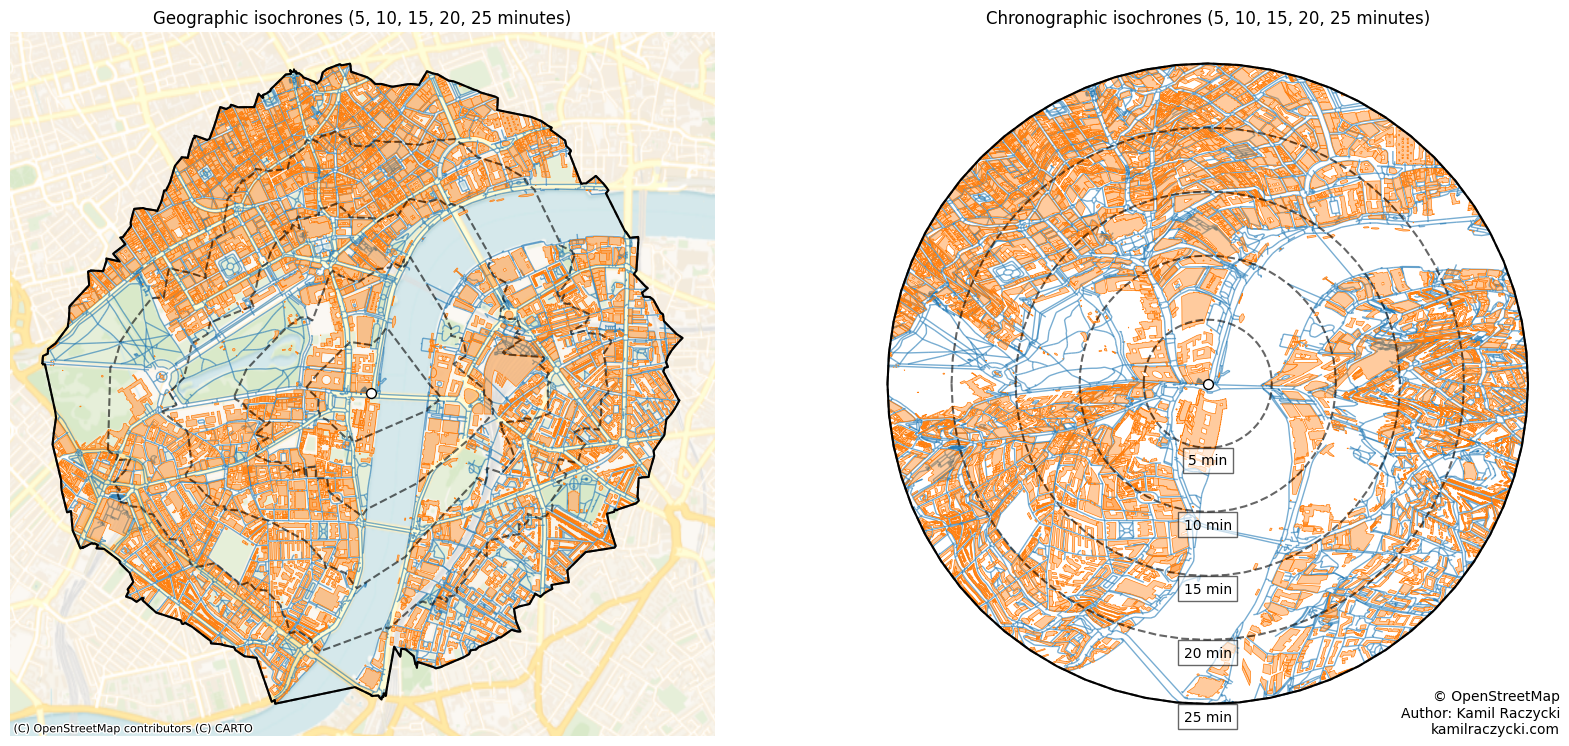

In [20]:
plot_default_colours()

Plotting data: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


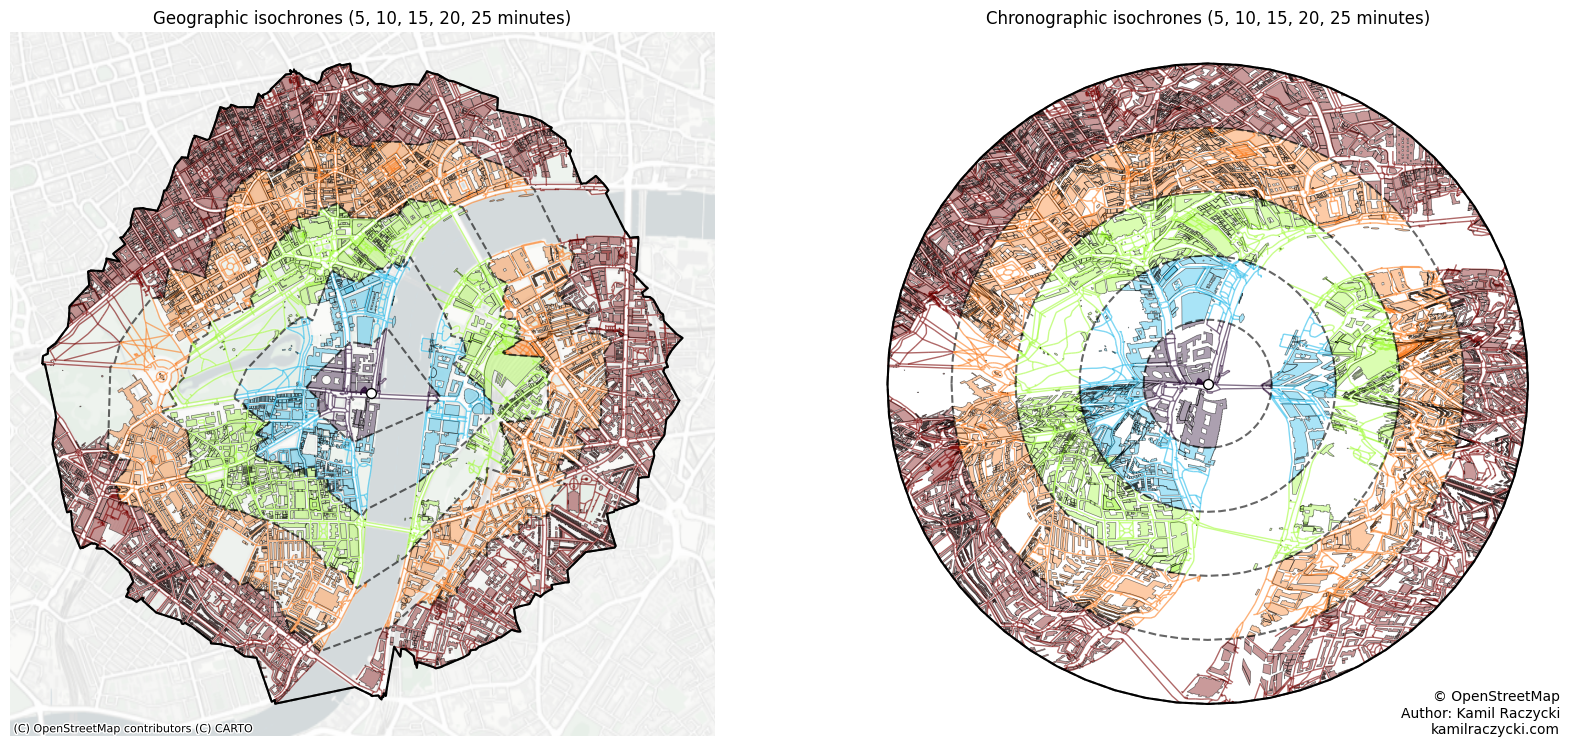

In [21]:
plot_gradient_steps()